In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings(action='ignore')

from utils import preprocessing as my_prep
from utils import regression as my_reg
from utils import evaluate as my_eval

# Data load

In [2]:
data_new = pd.read_csv("./data/seoul_preprocessed2_y_nextquarter.csv")
data_new.shape

(173745, 30)

In [3]:
data_new.describe()

,Unnamed: 0,Unnamed: 0.1,기준_년_코드,기준_분기_코드,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,연령대_10_유동인구_수,연령대_20_유동인구_수,연령대_30_유동인구_수,...,남성연령대_40_유동인_수,남성연령대_50_유동인_수,남성연령대_60_유동인_수,여성연령대_10_유동인_수,여성연령대_20_유동인_수,여성연령대_30_유동인_수,여성연령대_40_유동인_수,여성연령대_50_유동인_수,여성연령대_60_유동인_수,다음분기_매출_금액
count,173745.000000,173745.000000,173745.000000,173745.000000,1.737450e+05,1.737450e+05,1.737450e+05,173745.000000,1.737450e+05,1.737450e+05,...,173745.000000,173745.000000,173745.000000,173745.000000,1.737450e+05,173745.000000,173745.000000,173745.000000,173745.000000,1.737450e+05
mean,86872.000000,19029.921373,2017.909091,2.363636,4.601520e+05,2.277786e+05,2.323735e+05,40870.511733,1.181120e+05,9.163808e+04,...,39896.386774,31446.335647,32657.838384,20829.916297,6.375937e+04,42251.287231,33601.119802,32838.364488,39102.370376,6.035148e+08
std,50156.005598,11655.662245,0.792529,1.067943,6.351088e+05,3.098025e+05,3.280275e+05,64907.594876,2.503013e+05,1.342701e+05,...,53774.795283,37684.239137,42158.941155,35385.518060,1.407040e+05,61195.496546,41491.627558,37989.386280,53250.911260,1.842897e+09
min,0.000000,4.000000,2017.000000,1.000000,5.900000e+01,0.000000e+00,2.000000e+01,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2.569000e+03
25%,43436.000000,9111.000000,2017.000000,1.000000,1.398620e+05,7.155100e+04,6.733100e+04,6580.000000,2.976100e+04,2.854600e+04,...,13171.000000,11050.000000,8972.000000,3163.000000,1.513900e+04,12895.000000,11068.000000,11287.000000,8880.000000,5.279846e+07
50%,86872.000000,18346.000000,2018.000000,2.000000,2.738870e+05,1.393200e+05,1.335630e+05,16674.000000,5.796900e+04,5.461700e+04,...,24652.000000,20905.000000,17906.000000,8234.000000,3.013700e+04,24958.000000,21214.000000,21698.000000,17892.000000,1.752682e+08
75%,130308.000000,28252.000000,2019.000000,3.000000,5.504420e+05,2.698680e+05,2.752790e+05,49232.000000,1.150120e+05,1.025780e+05,...,46592.000000,38676.000000,40754.000000,24352.000000,6.126800e+04,48429.000000,41232.000000,40427.000000,45648.000000,5.290441e+08
max,173744.000000,48530.000000,2019.000000,4.000000,7.690300e+06,3.809289e+06,4.058533e+06,942860.000000,4.260889e+06,2.109808e+06,...,898019.000000,508809.000000,672339.000000,575146.000000,2.412765e+06,960188.000000,614458.000000,519316.000000,622325.000000,7.651527e+10


### 분기별로 분할

In [4]:
quarters = ['2017_1', '2017_2', '2017_3', '2017_4', '2018_1', '2018_2', '2018_3', '2018_4', '2019_1', '2019_2', '2019_3']
datas = {}
for q in quarters:
    year, quarter = map(int, q.split("_"))
    
    bool_year = data_new.기준_년_코드==year
    bool_quarter = data_new.기준_분기_코드==quarter
    datas[q] = data_new[bool_year & bool_quarter] 
    
for key in datas.keys():
    print(key, datas[key].shape)

2017_1 (15795, 30)
2017_2 (15795, 30)
2017_3 (15795, 30)
2017_4 (15795, 30)
2018_1 (15795, 30)
2018_2 (15795, 30)
2018_3 (15795, 30)
2018_4 (15795, 30)
2019_1 (15795, 30)
2019_2 (15795, 30)
2019_3 (15795, 30)


# Split train, validate, test

In [5]:
trainfiles = ['2017_1', '2017_2', '2017_3', '2017_4', '2018_1', '2018_2', '2018_3']
validatefiles = []
testfiles = ['2018_4', '2019_1', '2019_2', '2019_3']  # 2019_1, 2019_2, 2019_3, 2019_4 맞추기

train, validate, test = my_prep.split_train_val_test_by_file(datas, trainfiles, validatefiles, testfiles, category='편의점')
print(train.shape, validate.shape, test.shape)

[train] 2017_1 : (1147, 30), accumulate : (1147, 30)
[train] 2017_2 : (1147, 30), accumulate : (2294, 30)
[train] 2017_3 : (1147, 30), accumulate : (3441, 30)
[train] 2017_4 : (1147, 30), accumulate : (4588, 30)
[train] 2018_1 : (1147, 30), accumulate : (5735, 30)
[train] 2018_2 : (1147, 30), accumulate : (6882, 30)
[train] 2018_3 : (1147, 30), accumulate : (8029, 30)
[test] 2018_4 : (1147, 30), accumulate : (1147, 30)
[test] 2019_1 : (1147, 30), accumulate : (2294, 30)
[test] 2019_2 : (1147, 30), accumulate : (3441, 30)
[test] 2019_3 : (1147, 30), accumulate : (4588, 30)
(8029, 30) (0, 0) (4588, 30)


### split x, y

In [6]:
#x_header = [x for x in train.columns if '연령대' in x and x.find('연령대')==0]
x_header = [x for x in train.columns if '남성연령대' in x or '여성연령대' in x]
y_header = ['다음분기_매출_금액']
print(x_header, y_header)

['남성연령대_10_유동인_수', '남성연령대_20_유동인_수', '남성연령대_30_유동인_수', '남성연령대_40_유동인_수', '남성연령대_50_유동인_수', '남성연령대_60_유동인_수', '여성연령대_10_유동인_수', '여성연령대_20_유동인_수', '여성연령대_30_유동인_수', '여성연령대_40_유동인_수', '여성연령대_50_유동인_수', '여성연령대_60_유동인_수'] ['다음분기_매출_금액']


In [7]:
x_train, y_train = my_prep.split_xy(train, x_header, y_header)
# x_validate, y_validate = my_prep.split_xy(validate, x_header, y_header)
x_test, y_test = my_prep.split_xy(test, x_header, y_header)

print('train', x_train.shape, y_train.shape)
# print('validate', x_validate, y_validate)
print('test', x_test.shape, y_test.shape)

train (8029, 12) (8029, 1)
test (4588, 12) (4588, 1)


### Option(random split)

In [8]:
x_train = np.concatenate((x_train, x_test))
y_train = np.concatenate((y_train, y_test))
print('train', x_train.shape, y_train.shape)

train (12617, 12) (12617, 1)


In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3)
print('train', x_train.shape, y_train.shape)
print('test', x_test.shape, y_test.shape)

train (8831, 12) (8831, 1)
test (3786, 12) (3786, 1)


In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler().fit(x_train)
x_train_scale = scaler.transform(x_train)
x_test_scale = scaler.transform(x_test)

scaler_y = StandardScaler().fit(y_train)
y_train_scale = scaler_y.transform(y_train)
y_test_scale = scaler_y.transform(y_test)

print('train', x_train_scale.shape, y_train_scale.shape)
print('test', x_test_scale.shape, y_test_scale.shape)

train (8831, 12) (8831, 1)
test (3786, 12) (3786, 1)


### Correlation coefficient

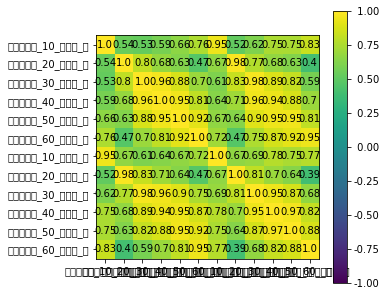

In [11]:
my_eval.visualize_CorrelCoeff_heatmap(x_train, x_header, figsize=(5, 5))

# Training

In [12]:
x_train_final, y_train_final = x_train, y_train
x_test_final, y_test_final = x_test, y_test

In [13]:
model_LR = my_reg.get_model_LinearRegression(x_train_final, y_train_final)
model_Elastic = my_reg.get_model_ElasticNet(x_train_final, y_train_final)
model_SVR = my_reg.get_model_SVR(x_train_final, y_train_final)

# hidden_layers = [512, 256, 4]
# model_MLPRegression = my_reg.get_model_MLPRegression(
#     x_train_scale, y_train_scale, 
#     hidden_layers=hidden_layers,
#     max_iter=5000,
#     alpha=0.0001,
#     random_state=42
# )

In [14]:
model_LR.coef_

array([[-7068.15969642,   371.1590387 , 17405.13195128,  6225.27528349,
         2204.61782673, -6285.2137972 ,  7041.14628186,   -85.20802869,
        -1584.85656177, -3169.43207239,  1568.15959623, -5124.06144422]])

### Keras (Tensorflow 2.2.0)

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.2.0


In [16]:
def build_model(input_shape):
    model = keras.Sequential([
    layers.Dense(12, activation='relu', input_shape=input_shape),
    layers.Dense(6, activation='relu'),
    layers.Dense(1)
    ])

    optimizer = keras.optimizers.Adam(learning_rate=0.00001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [17]:
model_MLPRegression = build_model(input_shape=[x_train_final.shape[1]])
model_MLPRegression.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                156       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________


In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

epo = 0
val_mse = 0
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        global epo
        global val_mse
        epo = epoch
        val_mse = logs['val_mse']
        
        if epoch % 50 == 0:
            print('.', end='')
            #print(logs)
        
# epoche 끝날때마다 모델 저장
# ModelCheck = ModelCheckpoint(os.path.join('./log', 'MLP_origin'+'-{epoch:04d}-{val_mse:.4f}.hdf5'), monitor='val_mse', verbose=0, 
#                          save_best_only=True, save_weights_only=False, mode='auto', period=1)

# metric의 상승이 멈출때마다 learning rate 낮춤
ReduceLR = ReduceLROnPlateau(monitor='val_mse', factor=0.2, mode='auto',
                          patience=5, min_lr=1e-6, verbose=1)

EarlyStop = EarlyStopping(monitor='val_mse', mode='auto', patience=10, restore_best_weights=True)

EPOCHS = 5000

history = model_MLPRegression.fit(
    x_train_final, y_train_final, 
    batch_size=32,epochs=EPOCHS, verbose=0,
    validation_data = (x_test_final, y_test_final),
    callbacks=[PrintDot(), ReduceLR, EarlyStop])

model_MLPRegression.save('./log/2MLP_origin-epoch:%04d-val_mse:%.4f}.hdf5' %(epo, val_mse))

....................................................................................................

In [19]:
model_MLPRegression(x_test_scale[0, :].reshape(1, 12))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[216.51617]], dtype=float32)>

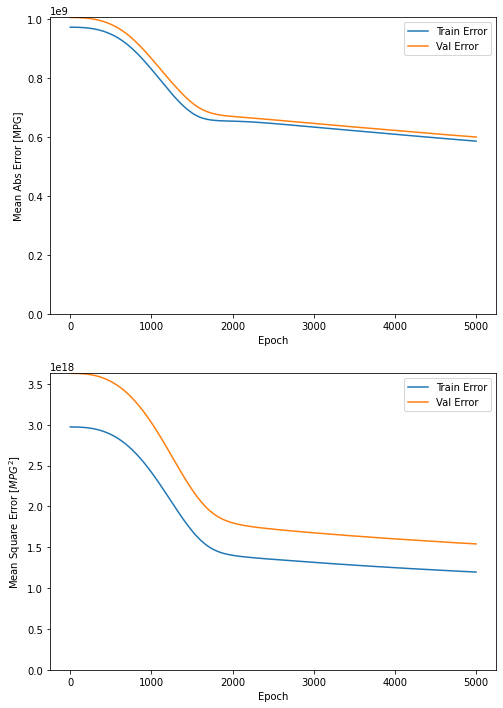

In [20]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.ylim([0,np.max(hist['val_mae'])+2])
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.ylim([0,np.max(hist['val_mse'])+2])
    plt.legend()
    plt.show()

plot_history(history)

# Evaluate

### Linear Regression

------- evaluate Linear Regression -------
RMSE : 1147573231.587553
R2 : 0.497543


MemoryError: Unable to allocate 225. GiB for an array with shape (30183109362,) and data type int64

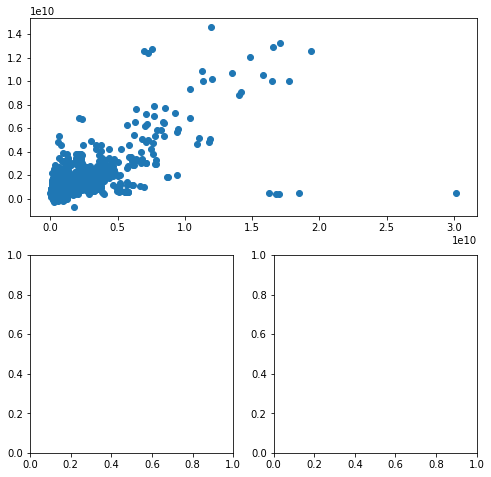

In [21]:
my_eval.eval_regression(y_test_final, model_LR.predict(x_test_final), model_name='Linear Regression')

### ElasticNet

In [ ]:
my_eval.eval_regression(y_test_final, model_Elastic.predict(x_test_final), model_name='ElasticNet')

### SVR

In [ ]:
my_eval.eval_regression(y_test_final, model_SVR.predict(x_test_final), model_name='SVM Regression')

# MLP Regressoin

In [ ]:
my_eval.eval_regression(y_test_final, model_MLPRegression.predict(x_test_final), model_name='MLP Regression')

# 오차 계산

In [ ]:
def evaluate_error(y_gt, y_pred, title=''):
    li_error = []
    for i in zip(y_gt, y_pred):
        error = (abs(i[0]-i[1])/i[0])
        li_error.append(error)

    print(sum(li_error), y_pred.shape[0])
    print('평균 오차 %.lf%%' %(np.mean(li_error)))
    print('최대 오차 %.lf%%' %(np.max(li_error)))
    print('최소 오차 %.lf%%' %(np.min(li_error)))

    #li_error.sort(reverse=True)
    #print('Top 10 오차 %s' %(li_error[:10]))
    plt.plot(li_error)
    plt.ylim([0, 100])
    plt.title(title)

In [ ]:
#### normed
y_pred_MLP = model_MLPRegression.predict(x_test_final)

#### non-normed
#y_pred_MLP = model_MLPRegression.predict(x_test_final)

evaluate_error(y_test[:, 0], y_pred_MLP, title='MLP error')

In [ ]:
y_pred_scale_LR = model_LR.predict(x_test_final)
y_pred_LR = scaler_y.inverse_transform(y_pred_scale_LR)

evaluate_error(y_test[:, 0], y_pred_LR, title="LR error")

In [ ]:
y_pred_scale_Elastic = model_Elastic.predict(x_test_final)
y_pred_Elastic = scaler_y.inverse_transform(y_pred_scale_Elastic)

evaluate_error(y_test[:, 0], y_pred_Elastic, title='Elastic error')

# Conclusion

##### 정답 값이 너무 비슷? 몇명만 너무 큼? 
##### 큰 의미가 없나?

In [ ]:
plt.plot(y_test)

In [ ]:
print('MLP', int(scaler_y.inverse_transform([-0.02651767])))
print('LR', int(scaler_y.inverse_transform([-0.06412931])))
#print('SVR', int(scaler_y.inverse_transform([-0.02651767])))
print('Elastic', int(scaler_y.inverse_transform([4.09963574e-10])))    #
print('ground truth', y_test[0, 0])

# TODO

1) 전처리  
- 가중치부여    

2) 차원축소  
 - wrapper, PCA    

3) 증분  
 - 회귀 증분?    

4) 모델 
 - LGBM, MLP monitoring  

5) 학습/검증 분할
 - random
 - k-fold(train,validate)/test
 - sequence  
 
6) 분석, 결론
 - MSE, R2
 - 오차
 - 시각화 (지도?)

버릴건 버려야